<h1>Notbook do analizy wyników algorytmu ACO dla 1200 próbek po od 4-15 miast wykonanych dla różnych wartości warametrów alpha i beta z przedziału 0.1-2.0</h1>

1. Import bibliotek

In [187]:
import pandas as pd
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from builders.PathBuilder import PathBuilder
from constants.AlgNamesResults.names import *
from os.path import exists
import seaborn as sns
%matplotlib inline

2. Przygotowanie zmiennych do ekstrakcji danych z plików CSV

In [188]:
MEASUREMENTS = "measurements"
NAME_DIR_WITH_RESULTS_CSV = "aco_test_range_alpha_beta_pop_100_nr_iter_20_rho_0_7"
CSV = "csv"
CPU = "CPU"
TIME_AND_DATA = "TIME_AND_DATA"
TIME_AND_MEMORY = "TIME_AND_MEMORY"
NUMBER_OF_CITIES = "number_of_cities"
INDEX_OF_SAMPLE = "index_of_sample"
BEST_WAY_IS_OPTIMAL = "best_way_is_optimal"
RELATIVE_DISTANCE_ERROR = "relative_distance_error"
TIME_DURATION_IS_SEC = "time_duration_is_sec"
DEFAULT_COLUMNS = [NUMBER_OF_CITIES, INDEX_OF_SAMPLE]
FEATURE_COLUMNS = []
BASIC_COLUMNS = DEFAULT_COLUMNS + FEATURE_COLUMNS
CPU_COLUMNS = BASIC_COLUMNS + []
TIME_AND_DATA_COLUMNS = BASIC_COLUMNS + [
                                           BEST_WAY_IS_OPTIMAL,
                                           RELATIVE_DISTANCE_ERROR,
                                           TIME_DURATION_IS_SEC
                                          ]
TIME_AND_MEMORY_COLUMNS = BASIC_COLUMNS + []
#NAME OF PARAMETERS
ALPHA = "ALPHA"
BETA = "BETA"
RHO = "RHO"
POPULATION = "POPULATION"
NR_ITER ="NR_ITER"
CSV_NAME = "CSV_NAME"
PATTERN_CSV_NAME = "%s_ACO_POP_%d_ALPHA_%s_BETA_%s_RHO_%s_NR_ITER_%d"
PARAMETERS_RANGE_DICT = {
    ALPHA: [0.5,1.0, 1.5, 2.0],
    BETA: [0.5,1.0, 1.5, 2.0],
    RHO: 0.7,
    NR_ITER: 20,
    POPULATION: 100
}


def float_to_str(float_value):
    return str(float_value).replace(".", "_")

3. Zdefiniowanie funckji do wygenerowania nazwy pliku CSV z pomiarami na podstawie patterna i wartości parametrów

In [189]:
def generate_name_of_csv(type_measurement, population, alpha, beta, rho, nr_iter):
    alpha_str = float_to_str(alpha)
    beta_str = float_to_str(beta)
    rho_str = float_to_str(rho)
    return PATTERN_CSV_NAME % (type_measurement, population, alpha_str, beta_str, rho_str, nr_iter)

4. Zdefiniowanie funkcji do wygenerowania wszystkich kombinacji nazw plików CSV z pomiarami

In [190]:
def generate_config_combinations(type_of_measure):
    COMBINATIONS_CSV_NAMES = list()
    for alpha in PARAMETERS_RANGE_DICT[ALPHA]:
        for beta in PARAMETERS_RANGE_DICT[BETA]:
            tmp_dict = dict()
            tmp_dict[ALPHA] = alpha
            tmp_dict[BETA] = beta
            tmp_dict[RHO] = PARAMETERS_RANGE_DICT[RHO]
            name_of_csv = generate_name_of_csv(type_of_measure,
                                              PARAMETERS_RANGE_DICT[POPULATION],
                                              float_to_str(alpha),
                                              float_to_str(beta),
                                              float_to_str(PARAMETERS_RANGE_DICT[RHO]),
                                              PARAMETERS_RANGE_DICT[NR_ITER])
            tmp_dict[CSV_NAME] = name_of_csv            
            COMBINATIONS_CSV_NAMES.append(tmp_dict)
    return COMBINATIONS_CSV_NAMES

5. Zdefiniowanie funckji do pozykiwania sub DataFrame dla zadanych kolumn skojarzonych z typem pomiaru

In [191]:
def get_column_list(type_measurement):
    switcher = {
        TIME_AND_DATA: TIME_AND_DATA_COLUMNS,
        CPU: CPU_COLUMNS,
        TIME_AND_MEMORY: TIME_AND_MEMORY_COLUMNS
    }
    return switcher[type_measurement]

6. Zdefiniowanie funkcji do otrzymania scieżki do pliku CSV z pomiarami

In [192]:
def get_path_to_csv(name_of_csv_file):
    return PathBuilder()\
            .add_dir(MEASUREMENTS)\
            .add_dir(NAME_DIR_WITH_RESULTS_CSV)\
            .add_file(name_of_csv_file, "csv")\
            .build()

7. Zdefiniowanie funckji by dodać kolumnę z danymi do DataFrame jeśli jeszcze nie istnieje

In [193]:
def add_column_to_df_if_not_exist(df, column_name, series_to_column, index_column_to_insert=0, allow_duplicates=True):
    if column_name not in df.columns:
        columns_count = len(df.columns)
        rows_count = len(df.index)
        if index_column_to_insert > columns_count:
            raise Exception("Index of column is out of range")
        if len(series_to_column) > rows_count:
            raise Exception("Series of data have diffrent length as number rows in DataFrame, series_rows: %d | DataFrame rows %d" % (len(series_to_column), rows_count))
        df.insert(index_column_to_insert, column_name, series_to_column, allow_duplicates)
    return df

8. Zdefiniowanie funkcji do przygotowania mapy nazw plików csv z ich odczytanymi DataFrame

In [215]:
def prepare_csv_data_dictionary(type_of_measure):
    result_dictionary = dict()
    names = list()
    for csv_file_config in generate_config_combinations(type_of_measure):
        path_to_csv = get_path_to_CSV(csv_file_config[CSV_NAME])
        if exists(path_to_csv):
            name_of_csv_file = csv_file_config[CSV_NAME]
            names.append(name_of_csv_file)
            df = pd.read_csv(path_to_csv)
            df.dropna(axis=1, inplace=True)
            df.replace("Nan", "", inplace=True)
            # Dodawanie nowych kolumn
            rows_count = len(df.index)
            df = add_column_to_df_if_not_exist(df, "alpha",[csv_file_config[ALPHA]] * rows_count,2)
            df = add_column_to_df_if_not_exist(df, "beta",[csv_file_config[BETA]] * rows_count,3)
            # Zmniejszenie ilości kolumn w DataFrame
            list_columns_for_sub_df = get_column_list(type_of_measure)
            df = df[list_columns_for_sub_df]
            result_dictionary[name_of_csv_file] = df
    return result_dictionary, names

9. Zdefiniowanie funckji do przygotowania mapy ciepła dla liczby miast i indexów próebek i zadanej cechy

In [216]:
def preapre_dictionary_to_heat_map_for_nr_cities_and_index_samples(df, feature_to_heat_map):
    DICTIONARY_TO_HEAT_TABLE = dict()
    for row in df.iterrows():
        row = row[1]
        number_of_cities = row[NUMBER_OF_CITIES]
        index_of_sample = row[INDEX_OF_SAMPLE]
        feature_values = row[feature_to_heat_map]
        if number_of_cities not in DICTIONARY_TO_HEAT_TABLE:
            DICTIONARY_TO_HEAT_TABLE[number_of_cities] = list()
        DICTIONARY_TO_HEAT_TABLE[number_of_cities].append(feature_values)
    return DICTIONARY_TO_HEAT_TABLE

10. Zdefiniowanie funckji do utworzenia słownika alpha->beta->DataFrame

In [217]:
def prepare_dictionary_alpha_beta_df(type_of_measure, csv_dict):
    DICT_APLHA_BETA_CSV_DICT = dict()
    for alpha in PARAMETERS_RANGE_DICT[ALPHA]:
        DICT_APLHA_BETA_CSV_DICT[alpha] = dict()
        for beta in PARAMETERS_RANGE_DICT[BETA]:
            DICT_APLHA_BETA_CSV_DICT[alpha][beta] = dict()
            name_of_csv = get_file_name(type_of_measure,
                                        PARAMETERS_RANGE_DICT[POPULATION],
                                        alpha,
                                        beta,
                                        PARAMETERS_RANGE_DICT[RHO],
                                        PARAMETERS_RANGE_DICT[NR_ITER])
            df = csv_dict[name_of_csv]
            DICT_APLHA_BETA_CSV_DICT[alpha][beta] = df
    return DICT_APLHA_BETA_CSV_DICT

12. Zdefiniowanie funkcji do obliczenia wartości statystycznej z serii danych

In [235]:
def count_stats_from_series(series_with_data, stats):
    if stats is not None:
        if stats == "min":
            return series_with_data.min()
        if stats == "avg":
            return series_with_data.mean()
        if stats == "sum":
            return series_with_data.sum()
        if stats == "log_sum":
            return math.log(series_with_data.sum())
        if stats == "max":
            return series_with_data.max()
        if stats == "q1":
            return series_with_data.quantile(.25)
        if stats == "q3":
            return series_with_data.quantile(.75)
        if stats == "stdev":
            return series_with_data.std()
        return None

11. Zdefiniowanie funkcji do przygotowania słownika dla mapy ciepła dla alpha i beta i zadanej wartości cechy

In [219]:
def prepare_dictionary_alpha_beta_stats_value(dictionary_alpha_beta_df, feature_to_heat_map, stats):
    alpha_beta_stats_value_dict = dict()
    for alpha in PARAMETERS_RANGE_DICT[ALPHA]:
        alpha_beta_stats_value_dict[alpha] = dict()
        for beta in PARAMETERS_RANGE_DICT[BETA]:
#             alpha_beta_stats_value_dict[alpha][beta] = dict()
            if alpha in dictionary_alpha_beta_df:
                if beta in dictionary_alpha_beta_df[alpha]:
                    df = dictionary_alpha_beta_df[alpha][beta]
                    feature_values_as_series = df[feature_to_heat_map]
                    value = count_stats_from_series(feature_values_as_series, stats)
                    alpha_beta_stats_value_dict[alpha][beta] = value
    return alpha_beta_stats_value_dict

12. Zdefiniowanie funkcji do spłaszczania struktury słownikowej

In [220]:
def flat_dictionary_alpha_beta(dictionary_alpha_beta_stat_value):
    DICTIONARY_TO_HEAT_TABLE = dict()
    for alpha in PARAMETERS_RANGE_DICT[ALPHA]:
        DICTIONARY_TO_HEAT_TABLE[alpha] = list()
        for beta in PARAMETERS_RANGE_DICT[BETA]:
            value = dictionary_alpha_beta_stat_value[alpha][beta]
            DICTIONARY_TO_HEAT_TABLE[alpha].append(value)
    return DICTIONARY_TO_HEAT_TABLE

Prezentacja mapy cieplnej średniej wartości błędu względnego dla danej wartości parametru alfa i beta

Text(0.0, 1.0, 'ŚREDNIA WARTOŚĆ BŁĘDU WZGLĘDNEGO DLA ZADANEJ WARTOŚCI PARAMETRU ALFA I BETA I RHO= 0.7 DLA ALGORYTMU ACO')

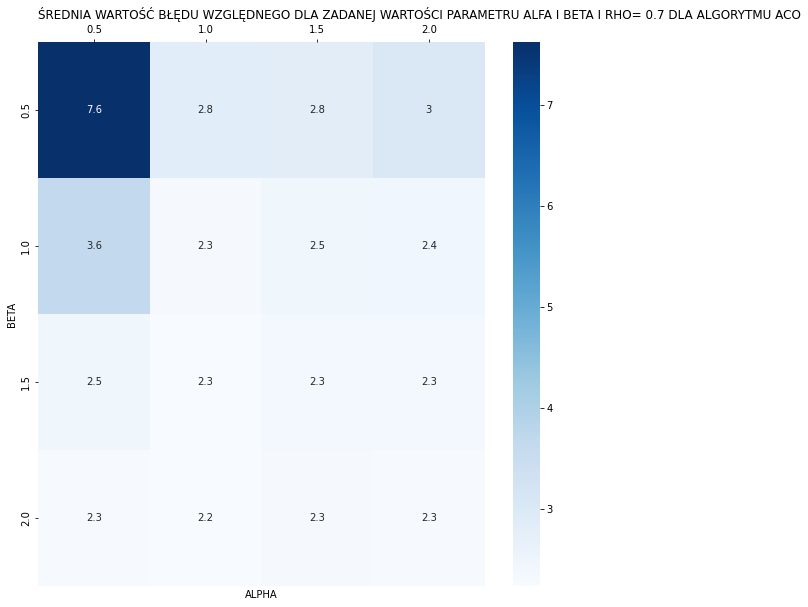

In [232]:
csv_dict, names = prepare_csv_data_dictionary(TIME_AND_DATA)
alpha_beta_df_dict = prepare_dictionary_alpha_beta_df(TIME_AND_DATA, csv_dict)
alpha_beta_static_value_dict = prepare_dictionary_alpha_beta_stats_value(alpha_beta_df_dict,
                                                                                 RELATIVE_DISTANCE_ERROR,
                                                                                 "avg")
dict_alpha_beta_to_heat_map = flat_dictionary_alpha_beta(alpha_beta_static_value_dict)
heat_table_df = pd.DataFrame.from_dict(dict_alpha_beta_to_heat_map)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(heat_table_df, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.5, 1.0, 1.5, 2.0]
yticks_labels = [0.5, 1.0, 1.5, 2.0]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('ALPHA')
plt.ylabel('BETA')

# title
title = 'Średnia wartość błędu względnego dla zadanej wartości parametru ALFA i BETA i RHO= 0.7 dla algorytmu ACO'.upper()
plt.title(title, loc='left')

Text(0.0, 1.0, 'MAKSYMALNA WARTOŚĆ BŁĘDU WZGLĘDNEGO DLA ZADANEJ WARTOŚCI PARAMETRU ALFA I BETA I RHO= 0.7 DLA ALGORYTMU ACO')

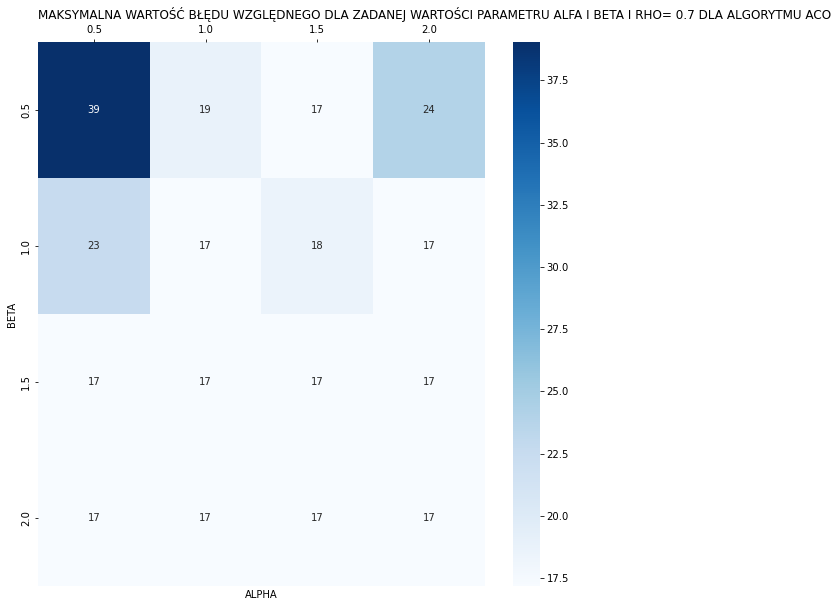

In [233]:
csv_dict, names = prepare_csv_data_dictionary(TIME_AND_DATA)
alpha_beta_df_dict = prepare_dictionary_alpha_beta_df(TIME_AND_DATA, csv_dict)
alpha_beta_static_value_dict = prepare_dictionary_alpha_beta_stats_value(alpha_beta_df_dict,
                                                                                 RELATIVE_DISTANCE_ERROR,
                                                                                 "max")
dict_alpha_beta_to_heat_map = flat_dictionary_alpha_beta(alpha_beta_static_value_dict)
heat_table_df = pd.DataFrame.from_dict(dict_alpha_beta_to_heat_map)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(heat_table_df, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.5, 1.0, 1.5, 2.0]
yticks_labels = [0.5, 1.0, 1.5, 2.0]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('ALPHA')
plt.ylabel('BETA')

# title
title = 'Maksymalna wartość błędu względnego dla zadanej wartości parametru ALFA i BETA i RHO= 0.7 dla algorytmu ACO'.upper()
plt.title(title, loc='left')

Text(0.0, 1.0, 'SUMA WARTOŚĆ BŁĘDU WZGLĘDNEGO DLA ZADANEJ WARTOŚCI PARAMETRU ALFA I BETA I RHO= 0.7 DLA ALGORYTMU ACO')

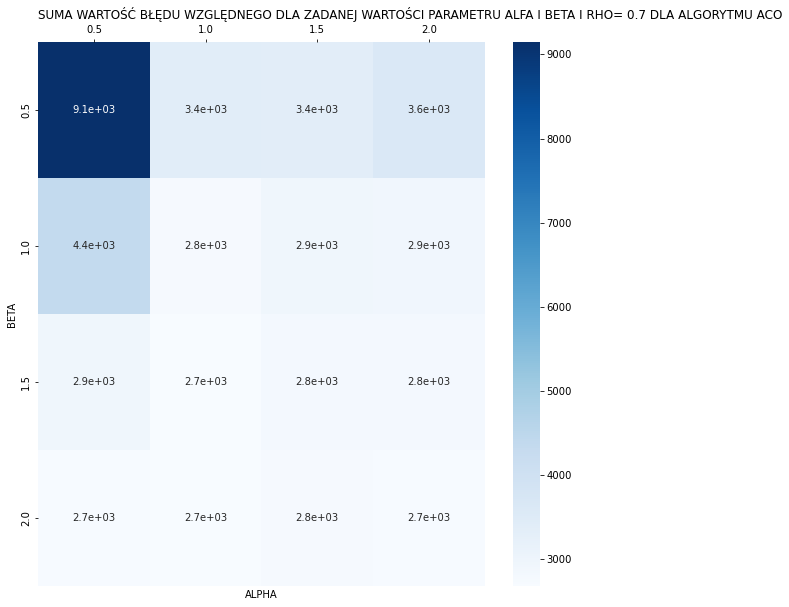

In [237]:
csv_dict, names = prepare_csv_data_dictionary(TIME_AND_DATA)
alpha_beta_df_dict = prepare_dictionary_alpha_beta_df(TIME_AND_DATA, csv_dict)
alpha_beta_static_value_dict = prepare_dictionary_alpha_beta_stats_value(alpha_beta_df_dict,
                                                                                 RELATIVE_DISTANCE_ERROR,
                                                                                 "sum")
dict_alpha_beta_to_heat_map = flat_dictionary_alpha_beta(alpha_beta_static_value_dict)
heat_table_df = pd.DataFrame.from_dict(dict_alpha_beta_to_heat_map)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(heat_table_df, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.5, 1.0, 1.5, 2.0]
yticks_labels = [0.5, 1.0, 1.5, 2.0]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('ALPHA')
plt.ylabel('BETA')

# title
title = 'Suma wartość błędu względnego dla zadanej wartości parametru ALFA i BETA i RHO= 0.7 dla algorytmu ACO'.upper()
plt.title(title, loc='left')

In [ ]:
heat_table_df = pd.DataFrame.from_dict(dict_alpha_beta_to_heat_map)
fig, ax = plt.subplots(figsize=(12,17))  
sns.heatmap(heat_table_df, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.5, 1.0, 1.5, 2.0]
yticks_labels = [0.5, 1.0, 1.5, 2.0]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Ilość miast')
plt.ylabel('index próbki')

# title
title = 'Czas wykoania algorytmu w sekundach dla algorytmu PSO dla optymalnie dobranych parametrów'.upper()
plt.title(title, loc='left')
# plt.savefig('time_exec_diagram.png')

In [64]:
DICTIONARY_TO_HEAT_TABLE =\
preapre_dictionary_to_heat_map_for_nr_cities_and_index_samples(df,"time_duration_is_sec")
df2 = pd.DataFrame.from_dict(DICTIONARY_TO_HEAT_TABLE)
df2
        

,4,5,6,7,8,9,10,11,12,13,14,15
0,0.302402,0.391884,0.533646,0.629462,0.773658,0.820067,0.906906,1.005506,1.169644,1.214465,1.353057,1.587064
1,0.304908,0.406988,0.538677,0.678341,0.730892,0.880718,0.895249,1.109506,1.103556,1.267410,1.340284,1.434517
2,0.305982,0.410607,0.536477,0.626994,0.698489,0.790296,0.927009,1.055953,1.183666,1.239398,1.347821,1.483562
3,0.307950,0.402736,0.500484,0.596251,0.691834,0.808611,0.909099,1.033610,1.118125,1.243767,1.339849,1.475813
4,0.298284,0.394776,0.488021,0.668553,0.724927,0.837772,0.951235,1.051397,1.152269,1.333598,1.367646,1.479266
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.326299,0.404261,0.500772,0.626424,0.701364,0.794036,0.911953,1.071298,1.144082,1.232024,1.455254,1.416314
96,0.300653,0.393770,0.543230,0.605932,0.720553,0.834663,0.949677,1.047856,1.224797,1.214301,1.466661,1.435263
97,0.288195,0.416350,0.492780,0.665621,0.726250,0.804494,0.911236,1.044072,1.168892,1.285198,1.407692,1.583116
98,0.300986,0.428177,0.508050,0.634165,0.757784,0.840397,0.897297,1.027176,1.116254,1.327622,1.458459,1.447234


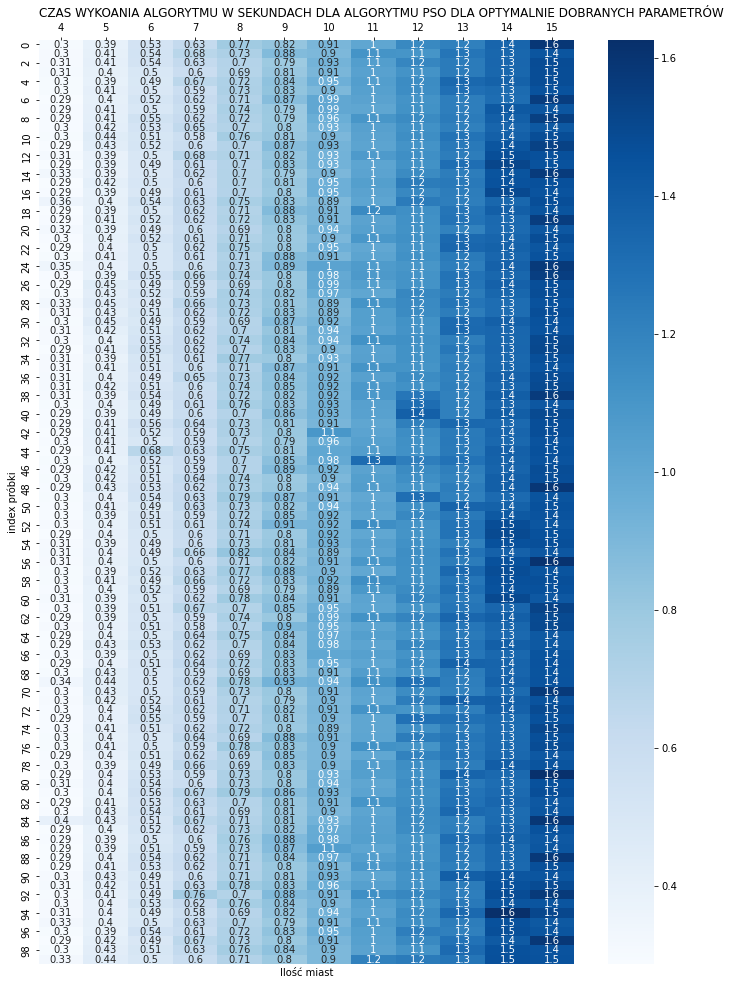

In [65]:
fig, ax = plt.subplots(figsize=(12,17))  
sns.heatmap(df2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
# xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
# plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Ilość miast')
plt.ylabel('index próbki')

# title
title = 'Czas wykoania algorytmu w sekundach dla algorytmu PSO dla optymalnie dobranych parametrów'.upper()
plt.title(title, loc='left')
plt.savefig('time_exec_diagram.png')

In [66]:
DICTIONARY_TO_HEAT_TABLE =\
preapre_dictionary_to_heat_map_for_nr_cities_and_index_samples(df,"relative_distance_error")
df3 = pd.DataFrame.from_dict(DICTIONARY_TO_HEAT_TABLE)
df3

,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000,5.345199,0.000000,0.517047,6.681577,9.901230,5.122529,17.966363,11.061527,26.165593,20.807538
1,14.448953,0.000000,2.690502,0.000000,6.188964,0.000000,1.494126,8.796884,8.819625,21.362590,13.513908,18.134443
2,0.448671,0.000000,0.000000,3.869777,0.000000,0.347985,8.510257,12.721327,0.000000,19.803325,21.340869,30.472718
3,0.000000,0.000000,0.000000,0.000000,3.895337,6.132462,8.700080,9.729672,23.442752,22.361428,24.161769,15.112670
4,0.000000,0.000000,0.641544,1.360894,0.814243,0.000000,7.106033,3.779992,15.106526,23.962382,14.977399,31.435397
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,10.501825,0.000000,11.589227,5.172012,4.219307,13.413907,22.139981,17.684507,31.042334
96,0.000000,0.000000,5.894007,7.067582,2.538902,0.000000,1.731808,9.837007,1.208956,15.907941,13.448302,20.312475
97,0.000000,3.317763,0.000000,0.000000,0.000000,0.000000,1.224779,4.184414,5.574431,14.471289,11.260429,25.710324
98,0.000000,0.000000,0.000000,0.000000,0.000000,2.536132,6.160870,6.416418,7.670079,13.289296,25.714334,20.162228


Text(0.0, 1.0, 'BŁĄD WZGLĘDNY DLA ALGORYTMU PSO DLA OPTYMALNIE DOBRANYCH PARAMETRÓW')

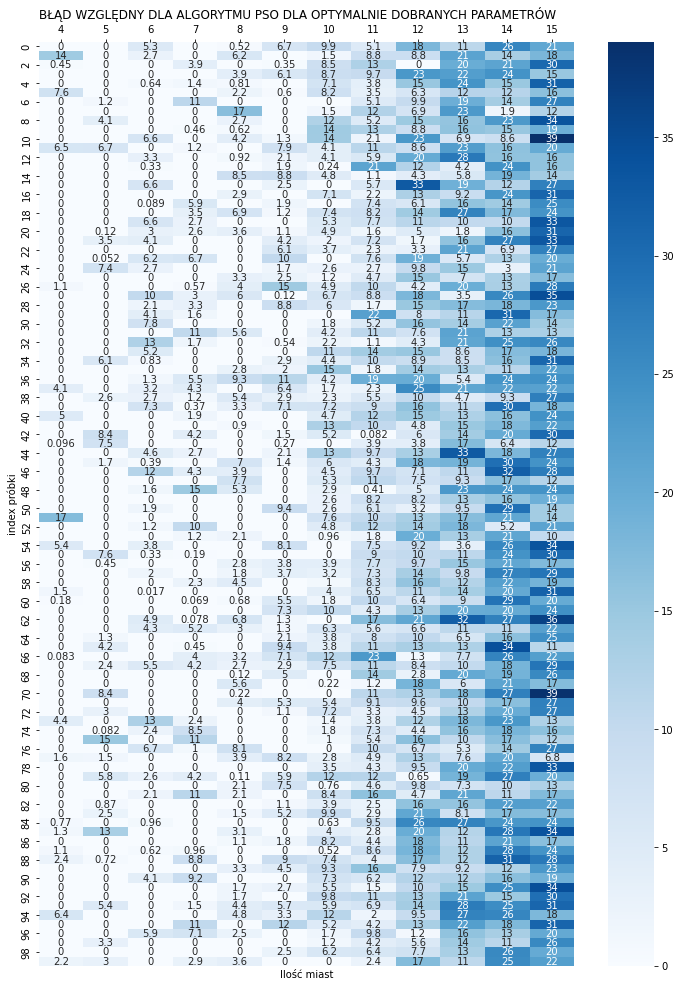

In [67]:
fig, ax = plt.subplots(figsize=(12,17))  
sns.heatmap(df3, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
plt.xlabel('Ilość miast')
plt.ylabel('index próbki')
# title
title = 'Błąd względny dla algorytmu PSO dla optymalnie dobranych parametrów'.upper()
plt.title(title, loc='left')

3. Opracowanie funkcji do zliczania danych

In [68]:

def generate_dictionary_alpha_beta(type_of_measure):
    configs = generate_config_combinations(type_of_measure)
    csv_results_by_alpha_beta = dict()
    for config in configs:
        name_of_csv = config[CSV_NAME]
        df = csv_results_dict[name_of_csv]
        alpha = config[ALPHA]
        beta = config[BETA]
        if alpha not in csv_results_by_alpha_beta:
            csv_results_by_alpha_beta[alpha] = dict()
            csv_results_by_alpha_beta[alpha][beta] = df
        else:
            csv_results_by_alpha_beta[alpha][beta] = df
    return csv_results_by_alpha_beta

def generate_data_fram_with_alpha_beta_and_optimal_percentage(csv_results_dict,type_of_measure, stat):
    # [NUMBER_OF_CITIES][4]-[15]
    # [0][MIN_RELATIVE_DISTANCE_ERROR]
    # .
    # [99]
    configs = generate_config_combinations(type_of_measure)
    names = csv_results_dict.keys()
    TABLE = dict()
    alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    beta_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    csv_results_by_alpha_beta = generate_dictionary_alpha_beta(type_of_measure)
    for alpha in alpha_range:
        for beta in beta_range:
            df = csv_results_by_alpha_beta[alpha][beta]
            series = df["best_way_is_optimal"]
            true_false_percentage = series.value_counts(normalize=True, ascending = True)
            value = 0.0
            if stat == "optimal_to_all_percentage":
                value = true_false_percentage[0]
            elif stat == "not_optimal_to_all_percentage":
                value = true_false_percentage[1]
            if alpha not in TABLE:
                TABLE[alpha] = list()
                TABLE[alpha].append(value)
            else:
                TABLE[alpha].append(value)
    return TABLE

def generate_data_fram_with_stats(csv_results_dict,type_of_measure,column_name,  stat):
    # [NUMBER_OF_CITIES][4]-[15]
    # [0][MIN_RELATIVE_DISTANCE_ERROR]
    # .
    # [99]
    configs = generate_config_combinations(type_of_measure)
    names = csv_results_dict.keys()
    TABLE = dict()
    alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    beta_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    csv_results_by_alpha_beta = generate_dictionary_alpha_beta(type_of_measure)
    for alpha in alpha_range:
        for beta in beta_range:
            df = csv_results_by_alpha_beta[alpha][beta]
            series = df[column_name]
            value = 0.0
            if stat == "min":
                value = series.min()
            elif stat == "avg":
                value = series.mean()
            elif stat == "max":
                value = series.max()
            elif stat == "stdev":
                value = series.std()
            elif stat == "sum":
                value = series.sum()
            elif stat == "log_sum":
                value = math.log(series.sum())
            elif stat == "q1":
                value = series.quantile(.25)
            elif stat == "q3":
                value = series.quantile(.75)
            if alpha not in TABLE:
                TABLE[alpha] = list()
                TABLE[alpha].append(value)
            else:
                TABLE[alpha].append(value)
    return TABLE     

4. Przygotowanie mapy ciepła dla danej wartości parametrów alfa i beta obrazującej wartość procentową ilości znalezionych optymalnych rozwiązań z użyciem algorytmu PSO

In [69]:
f = generate_data_fram_with_alpha_beta_and_optimal_percentage(csv_results_dict,
                                                              TIME_AND_DATA,
                                                              "optimal_to_all_percentage")
f2 = pd.DataFrame.from_dict(f)
f2.set_index(pd.Series([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Wartość parametru ALFA')
plt.ylabel('Wartość parametru BETA')

# title
title = 'Procent znalezionych optymalnych rozwiązań dla danej wartości parametru ALPHA i BETA dla algorytmu PSO'.upper()
plt.title(title, loc='left')

NameError: name 'csv_results_dict' is not defined